# Final Project 

- GitHub Username: sghazali272
- USC ID: 1482-3092-72
- Name: Sofian Ghazali

# Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import string
import re
from collections import Counter
import matplotlib.pyplot as plt
import warnings

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, MaxPooling1D, Flatten, Dropout
from keras.layers import LSTM
from tensorflow.keras.models import model_from_json
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Extracting Data

In [ ]:
filepath_pos = r'../Data/pos'
filepath_neg = r'../Data/neg'

file_names_pos = [filepath_pos+'/'+file for file in listdir(filepath_pos) if isfile(join(filepath_pos, file))]
file_names_neg = [filepath_neg+'/'+file for file in listdir(filepath_neg) if isfile(join(filepath_neg, file))]

pos_text = []
neg_text = []

for idx, path in enumerate(file_names_pos):
    with open(path, 'r') as f:
        pos_text.append(f.read())
    
    if idx > 0 and idx % 50 == 0:
        print(f'Extracted {idx} elements')

print('Done extracting the positive text documents.')

for idx, path in enumerate(file_names_neg):
    with open(path, 'r') as f:
        neg_text.append(f.read())
    
    if idx > 0 and idx % 50 == 0:
        print(f'Extracted {idx} elements')

print('Done extracting the negative text documents')

Extracted 50 elements
Extracted 100 elements
Extracted 150 elements
Extracted 200 elements
Extracted 250 elements
Extracted 300 elements
Extracted 350 elements
Extracted 400 elements
Extracted 450 elements
Extracted 500 elements
Extracted 550 elements
Extracted 600 elements
Extracted 650 elements
Extracted 700 elements
Extracted 750 elements
Extracted 800 elements
Extracted 850 elements
Extracted 900 elements
Extracted 950 elements
Done extracting the positive text documents.
Extracted 50 elements
Extracted 100 elements
Extracted 150 elements
Extracted 200 elements
Extracted 250 elements
Extracted 300 elements
Extracted 350 elements
Extracted 400 elements
Extracted 450 elements
Extracted 500 elements
Extracted 550 elements
Extracted 600 elements
Extracted 650 elements
Extracted 700 elements
Extracted 750 elements
Extracted 800 elements
Extracted 850 elements
Extracted 900 elements
Extracted 950 elements
Done extracting the negative text documents


In [ ]:
print(f'Total size of positive documents: {len(pos_text)}')
print(f'Total size of negative documents: {len(neg_text)}')

Total size of positive documents: 1000
Total size of negative documents: 1000


# 1b. Data Exploration and Pre-processing

<h2>- Splitting Data into Train/Test</h2>

- I will be splitting the positive and negative text into train/test data as well as make a larger dataframe combining all the documents. The larger dataframe will be used for Exploratory Data Analysis purposes such as finding unique words, review length and plotting histogram.

In [ ]:
# Train and Test Sets
df_train = pd.concat([pd.DataFrame({'Text': pos_text[:700], 'Label': 1}), pd.DataFrame({'Text': neg_text[:700], 'Label': 0})]).reset_index(drop=True)
df_test = pd.concat([pd.DataFrame({'Text': pos_text[700:], 'Label': 1}), pd.DataFrame({'Text': neg_text[700:], 'Label': 0})]).reset_index(drop=True)
# All the text documents for EDA purposes
df = pd.concat([pd.DataFrame({'Text': pos_text, 'Label': 1}), pd.DataFrame({'Text': neg_text, 'Label': 0})]).reset_index(drop=True)

In [ ]:
df_train.head()

,Text,Label
0,films adapted from comic books have had plenty...,1
1,every now and then a movie comes along from a ...,1
2,you've got mail works alot better than it dese...,1
3,""" jaws "" is a rare film that grabs your atten...",1
4,moviemaking is a lot like being the general ma...,1


In [ ]:
df_test.head()

,Text,Label
0,let me start off by saying that leading up to ...,1
1,"seen september 5 , 1998 at 10 p . m . at the s...",1
2,"the characters in "" palmetto "" collectively sw...",1
3,""" you've got mail "" is the very definition of...",1
4,with the sudden liberal emergence of personal ...,1


<h2>- Preprocessing: Removal of punctuation and numbers</h2>


- Removing the punctuation and numbers to get clean sentences.

In [ ]:
def preprocessing(x):
    # Removal of punctuation and numbers
    newline_removal = re.sub(r'\n', '', x.lower())
    punc_removal = newline_removal.translate(str.maketrans('', '', string.punctuation))
    num_removal = re.sub(r'[0-9]', '', punc_removal).strip() 

    return num_removal

df_train['clean_sentence'] = df_train['Text'].apply(lambda x: preprocessing(x))
df_test['clean_sentence'] = df_test['Text'].apply(lambda x: preprocessing(x))
df['clean_sentence'] = df['Text'].apply(lambda x: preprocessing(x))

In [ ]:
df_train.head()

,Text,Label,clean_sentence
0,films adapted from comic books have had plenty...,1,films adapted from comic books have had plenty...
1,every now and then a movie comes along from a ...,1,every now and then a movie comes along from a ...
2,you've got mail works alot better than it dese...,1,youve got mail works alot better than it deser...
3,""" jaws "" is a rare film that grabs your atten...",1,jaws is a rare film that grabs your attention...
4,moviemaking is a lot like being the general ma...,1,moviemaking is a lot like being the general ma...


In [ ]:
df.tail()

,Text,Label,clean_sentence
1995,"if anything , "" stigmata "" should be taken as ...",0,if anything stigmata should be taken as a w...
1996,"john boorman's "" zardoz "" is a goofy cinematic...",0,john boormans zardoz is a goofy cinematic de...
1997,the kids in the hall are an acquired taste . \...,0,the kids in the hall are an acquired taste it...
1998,there was a time when john carpenter was a gre...,0,there was a time when john carpenter was a gre...
1999,two party guys bob their heads to haddaway's d...,0,two party guys bob their heads to haddaways da...


<h2>- Number of Unique Words</h2>

In [ ]:
unique_words = []

for i in range(len(df)):
  tokens = word_tokenize(df['clean_sentence'].iloc[i])
  unique_words.extend(tokens)

unique_words = set(unique_words)

print(f'Number of unique words: {len(unique_words)}')

Number of unique words: 46825


<h2>- Average Review Length and Standard Deviation</h2>

In [ ]:
df['Review Length'] = df['clean_sentence'].apply(lambda x: len(word_tokenize(x)))

,Text,Label,clean_sentence,Review Length
0,films adapted from comic books have had plenty...,1,films adapted from comic books have had plenty...,679
1,every now and then a movie comes along from a ...,1,every now and then a movie comes along from a ...,650
2,you've got mail works alot better than it dese...,1,youve got mail works alot better than it deser...,416
3,""" jaws "" is a rare film that grabs your atten...",1,jaws is a rare film that grabs your attention...,997
4,moviemaking is a lot like being the general ma...,1,moviemaking is a lot like being the general ma...,644


In [ ]:
print(f'Average Review Length: {np.mean(df["Review Length"].values)}')
print(f'Standard Deviation of Review Length: {np.std(df["Review Length"].values)}')

Average Review Length: 644.473
Standard Deviation of Review Length: 285.0264571421397


<h2>- Histogram of Review Lengths</h2>

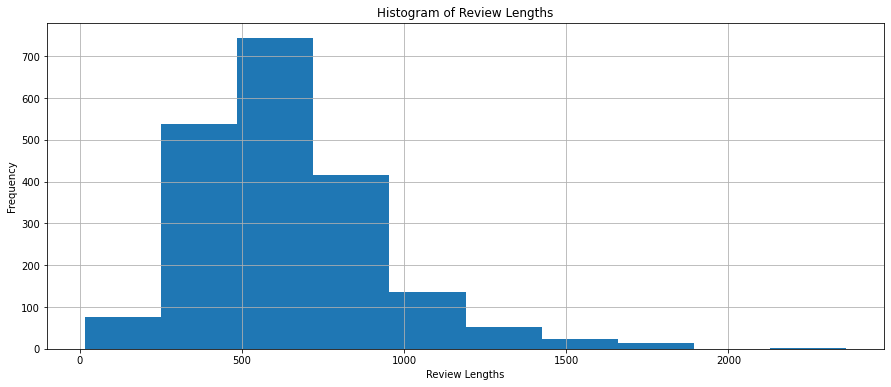

In [ ]:
plt.figure(figsize=(15,6))
plt.hist(df["Review Length"].values.tolist())
plt.xlabel('Review Lengths')
plt.ylabel('Frequency')
plt.title('Histogram of Review Lengths')
plt.grid()

- The above histogram suggests that there is a high frequency of documents that have review lengths anywhere between 500-650 while review lengths greater than 1000 are rarer.

<h2>- Preprocessing: Tokenization based on Popularity Rank of Words</h2>

- For the tokenization, I will be applying this procedure on the train set to capture the top 5000 most frequent words and finding their word indexes.
- I will apply on the train set and then use the learned vocabulary to transform the test set.

In [ ]:
# Setting the num_words to be 5000 based on word frequency.
# Fitting on the train set and applying the transformation to the test set.
tok = Tokenizer(5000)
tok.fit_on_texts(df_train['clean_sentence'].values.tolist())
tokenized_train = tok.texts_to_sequences(df_train['clean_sentence'].values.tolist())
tokenized_test = tok.texts_to_sequences(df_test['clean_sentence'].values.tolist())

df_train['tokenized_sentence'] = tokenized_train
df_test['tokenized_sentence'] = tokenized_test

In [ ]:
df_train

,Text,Label,clean_sentence,tokenized_sentence
0,films adapted from comic books have had plenty...,1,films adapted from comic books have had plenty...,"[66, 3436, 31, 344, 1573, 32, 90, 1069, 4, 616..."
1,every now and then a movie comes along from a ...,1,every now and then a movie comes along from a ...,"[149, 141, 3, 97, 2, 28, 200, 256, 31, 2, 1574..."
2,you've got mail works alot better than it dese...,1,youve got mail works alot better than it deser...,"[715, 287, 4181, 376, 155, 59, 9, 1168, 5, 7, ..."
3,""" jaws "" is a rare film that grabs your atten...",1,jaws is a rare film that grabs your attention...,"[2677, 6, 2, 1520, 15, 8, 164, 565, 145, 9, 31..."
4,moviemaking is a lot like being the general ma...,1,moviemaking is a lot like being the general ma...,"[6, 2, 207, 38, 112, 1, 835, 2680, 4, 24, 463,..."
...,...,...,...,...
1395,house on haunted hill ( 1999 ) starring taye d...,0,house on haunted hill starring taye diggs ...,"[401, 19, 2402, 1533, 720, 3686, 1312, 4770, 5..."
1396,"fit for a ghoul's night out , fat girl stands ...",0,fit for a ghouls night out fat girl stands ca...,"[1794, 12, 2, 346, 40, 1876, 341, 1238, 186, 2..."
1397,""" marie couldn't talk , "" paulie , the parrot...",0,marie couldnt talk paulie the parrot star o...,"[661, 600, 4616, 1, 208, 4, 13, 183, 28, 590, ..."
1398,"well , here's a distasteful , thoroughly amate...",0,well heres a distasteful thoroughly amateuri...,"[83, 1710, 2, 1915, 8, 666, 30, 174, 2, 3261, ..."


In [ ]:
df_test

,Text,Label,clean_sentence,tokenized_sentence
0,let me start off by saying that leading up to ...,1,let me start off by saying that leading up to ...,"[481, 98, 454, 101, 21, 869, 8, 1149, 45, 5, 1..."
1,"seen september 5 , 1998 at 10 p . m . at the s...",1,seen september at p m at the sony nickel...,"[151, 29, 2789, 1517, 29, 1, 1479, 610, 11, 13..."
2,"the characters in "" palmetto "" collectively sw...",1,the characters in palmetto collectively swea...,"[1, 73, 7, 157, 5, 2109, 2344, 3, 22, 50, 1, 1..."
3,""" you've got mail "" is the very definition of...",1,youve got mail is the very definition of a c...,"[715, 287, 4181, 6, 1, 77, 4, 2, 1137, 28, 22,..."
4,with the sudden liberal emergence of personal ...,1,with the sudden liberal emergence of personal ...,"[11, 1, 2878, 4, 714, 7, 1, 1116, 4570, 47, 11..."
...,...,...,...,...
595,"if anything , "" stigmata "" should be taken as ...",0,if anything stigmata should be taken as a w...,"[51, 230, 162, 23, 568, 10, 2, 2002, 338, 66, ..."
596,"john boorman's "" zardoz "" is a goofy cinematic...",0,john boormans zardoz is a goofy cinematic de...,"[196, 6, 2, 1994, 1111, 39, 3, 3129, 8, 9, 213..."
597,the kids in the hall are an acquired taste . \...,0,the kids in the hall are an acquired taste it...,"[1, 390, 7, 1, 1530, 20, 24, 2394, 9, 888, 29,..."
598,there was a time when john carpenter was a gre...,0,there was a time when john carpenter was a gre...,"[52, 30, 2, 62, 43, 196, 2387, 30, 2, 123, 320..."


<h2>- Selecting a Review Length Threshold</h2>

In [ ]:
print(f'Review Length distribution: {np.quantile(df["Review Length"], [0.50, 0.70, 0.90])}')

Review Length distribution: [602.5 737.  993.4]


<h2>- Padding the Documents Vector</h2>

In [ ]:
train_tokenized = df_train['tokenized_sentence'].values.tolist()
test_tokenized = df_test['tokenized_sentence'].values.tolist()
padded_train = pad_sequences(train_tokenized, maxlen=737, value=0)
padded_test = pad_sequences(test_tokenized, maxlen=737, value=0)
print(padded_train.shape)
print(padded_test.shape)

(1400, 737)
(600, 737)


# 1c. Word Embeddings

In [ ]:
embed_layer = Embedding(5000, 32, input_length=737)

embedded_array_train = []
embedded_array_test = []

for doc in padded_train:
  doc = np.array(doc)
  embedded = np.array(embed_layer(doc))
  embedded = embedded.transpose()
  embedded_array_train.append(embedded)

for doc in padded_test:
  doc = np.array(doc)
  embedded = np.array(embed_layer(doc))
  embedded = embedded.transpose()
  embedded_array_test.append(embedded)

In [ ]:
# Train
print(f'Total Length of the documents: {len(embedded_array_train)}')
print(f'Dimension of each document: {embedded_array_train[0].shape}')

Total Length of the documents: 1400
Dimension of each document: (32, 737)


In [ ]:
# Test
print(f'Total Length of the documents: {len(embedded_array_test)}')
print(f'Dimension of each document: {embedded_array_test[0].shape}')

Total Length of the documents: 600
Dimension of each document: (32, 737)


<h2>- Flattening the Embedding Vector</h2>

In [ ]:
flattened_vector_train = [i.flatten() for i in embedded_array_train]
flattened_vector_test = [i.flatten() for i in embedded_array_test]
print((len(flattened_vector_train), len(flattened_vector_train[0])))
print((len(flattened_vector_test), len(flattened_vector_test[0])))

(1400, 23584)
(600, 23584)


# 1d. Multi-Layer Perceptron

In [ ]:
# Splitting the data into train and test sets for model learning
x_train = np.array(flattened_vector_train)
y_train = df_train['Label'].values
x_test = np.array(flattened_vector_test)
y_test = df_test['Label'].values

In [ ]:
# Defining a MLP pipeline
model = Sequential()
# Add first hidden dense layer with 50 'relu' neurons and 20% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# Add first hidden dense layer with 50 'relu' neurons and 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add first hidden dense layer with 50 'relu' neurons and 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add output layer with a sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=2, verbose=1, batch_size=10)

train_scores = model.evaluate(x_train, y_train, verbose=0)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_scores[0]} and Train Accuracy: {train_scores[1]*100}%')
print(f'Test Loss: {test_scores[0]} and Test Accuracy: {test_scores[1]*100}%')

Epoch 1/2
140/140 [==============================] - 3s 13ms/step - loss: 0.7046 - accuracy: 0.4836
Epoch 2/2
140/140 [==============================] - 1s 10ms/step - loss: 0.6839 - accuracy: 0.5479
Train Loss: 0.6306094527244568 and Train Accuracy: 66.07142686843872%
Test Loss: 0.6864634156227112 and Test Accuracy: 51.16666555404663%


<h4>- Experimentation with MLP: Increasing Epochs</h4>

In [ ]:
# Defining a MLP pipeline
model = Sequential()
# Add first hidden dense layer with 20% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# Add second hidden dense layer with 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add final hidden dense layer with 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add output layer with a sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, verbose=1, batch_size=10)

train_scores = model.evaluate(x_train, y_train, verbose=0)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_scores[0]} and Train Accuracy: {train_scores[1]*100}%')
print(f'Test Loss: {test_scores[0]} and Test Accuracy: {test_scores[1]*100}%')

Epoch 1/5
140/140 [==============================] - 3s 11ms/step - loss: 0.6991 - accuracy: 0.5343
Epoch 2/5
140/140 [==============================] - 1s 10ms/step - loss: 0.6784 - accuracy: 0.5650
Epoch 3/5
140/140 [==============================] - 1s 8ms/step - loss: 0.6235 - accuracy: 0.6386
Epoch 4/5
140/140 [==============================] - 1s 8ms/step - loss: 0.5052 - accuracy: 0.7321
Epoch 5/5
140/140 [==============================] - 1s 9ms/step - loss: 0.3464 - accuracy: 0.8457
Train Loss: 0.21654123067855835 and Train Accuracy: 87.85714507102966%
Test Loss: 1.007699728012085 and Test Accuracy: 55.33333420753479%


# 1e. One-Dimensional Convolutional Neural Network

In [ ]:
# Using the embedded data to split into train and test sets
x_train = np.array(embedded_array_train)
y_train = df_train['Label'].values
x_test = np.array(embedded_array_test)
y_test = df_test['Label'].values

In [ ]:
x_train.shape

(1400, 32, 737)

In [ ]:
# Defining a MLP pipeline
model = Sequential()
# Add convolutional layer and maxpooling layer
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
# Add first hidden dense layer with 20% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# Add second hidden dense layer with 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add final hidden dense layer with 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add output layer with a sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=2, verbose=1, batch_size=10)

train_scores = model.evaluate(x_train, y_train, verbose=0)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_scores[0]} and Train Accuracy: {train_scores[1]*100}%')
print(f'Test Loss: {test_scores[0]} and Test Accuracy: {test_scores[1]*100}%')

Epoch 1/2
140/140 [==============================] - 3s 15ms/step - loss: 0.6937 - accuracy: 0.5271
Epoch 2/2
140/140 [==============================] - 2s 13ms/step - loss: 0.6943 - accuracy: 0.5229
Train Loss: 0.6876974701881409 and Train Accuracy: 50.07143020629883%
Test Loss: 0.6921298503875732 and Test Accuracy: 50.0%


<h4>- Experimentation with CNN: Increase Epochs</h4>

In [ ]:
# Defining a MLP pipeline
model = Sequential()
# Add convolutional layer and maxpooling layer
model.add(Conv1D(32,3,activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
# Add first hidden dense layer with 20% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
# Add second hidden dense layer with 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add final hidden dense layer with 50% dropout
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.5))
# Add output layer with a sigmoid activation
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=5, verbose=1, batch_size=10)

train_scores = model.evaluate(x_train, y_train, verbose=0)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_scores[0]} and Train Accuracy: {train_scores[1]*100}%')
print(f'Test Loss: {test_scores[0]} and Test Accuracy: {test_scores[1]*100}%')

Epoch 1/5
140/140 [==============================] - 4s 19ms/step - loss: 0.6955 - accuracy: 0.4886
Epoch 2/5
140/140 [==============================] - 3s 18ms/step - loss: 0.6946 - accuracy: 0.5071
Epoch 3/5
140/140 [==============================] - 3s 18ms/step - loss: 0.6924 - accuracy: 0.5086
Epoch 4/5
140/140 [==============================] - 2s 16ms/step - loss: 0.6876 - accuracy: 0.5714
Epoch 5/5
140/140 [==============================] - 2s 14ms/step - loss: 0.6268 - accuracy: 0.6757
Train Loss: 0.3787792921066284 and Train Accuracy: 90.57142734527588%
Test Loss: 0.7187069654464722 and Test Accuracy: 54.333335161209106%


# 1f. Long Short-Term Recurrent Neural Network

In [ ]:
# Using the embedded dataset for train and test
x_train = np.array(embedded_array_train)
y_train = df_train['Label'].values
x_test = np.array(embedded_array_test)
y_test = df_test['Label'].values

In [ ]:
model = Sequential()
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.fit(x_train, y_train, epochs=20, verbose=1, batch_size=10)
train_scores = model.evaluate(x_train, y_train, verbose=0)
test_scores = model.evaluate(x_test, y_test, verbose=0)
print(f'Train Loss: {train_scores[0]} and Train Accuracy: {train_scores[1]*100}%')
print(f'Test Loss: {test_scores[0]} and Test Accuracy: {test_scores[1]*100}%')

Epoch 1/20
140/140 [==============================] - 6s 17ms/step - loss: 0.6938 - accuracy: 0.5100
Epoch 2/20
140/140 [==============================] - 2s 17ms/step - loss: 0.6784 - accuracy: 0.5964
Epoch 3/20
140/140 [==============================] - 2s 17ms/step - loss: 0.6136 - accuracy: 0.6643
Epoch 4/20
140/140 [==============================] - 2s 17ms/step - loss: 0.4709 - accuracy: 0.7864
Epoch 5/20
140/140 [==============================] - 2s 17ms/step - loss: 0.3498 - accuracy: 0.8486
Epoch 6/20
140/140 [==============================] - 2s 17ms/step - loss: 0.2181 - accuracy: 0.9164
Epoch 7/20
140/140 [==============================] - 2s 17ms/step - loss: 0.1439 - accuracy: 0.9464
Epoch 8/20
140/140 [==============================] - 2s 16ms/step - loss: 0.0931 - accuracy: 0.9636
Epoch 9/20
140/140 [==============================] - 2s 17ms/step - loss: 0.0534 - accuracy: 0.9829
Epoch 10/20
140/140 [==============================] - 2s 16ms/step - loss: 0.0285 - accura

# Observations

<h3>MLP</h3>

- MLP performed average when set to 2 epochs and batch size of 10 with a train accuracy of 66%. However, when I set the number of epochs to 5, the train accuracy jumped to 89% while the test accuracy for both experiments remained the same.

<h3>1D-CNN</h3>

- CNN showed very weak performance at 2 epochs and batch size of 10, with train and test performance only peaking at 50%, showing the model is not learning. However, when I bumped up the epochs to 5, the model showed massive improvement in train (90%) and good improvement in test accuracy (but 54%). 

<h3>LSTM</h3>

- LSTM shows good performance on train set at any epoch setting from 10-50. However, the test performance was really bad and shows the model is overfitting. The test accuracy seems to be the same no matter what changes I make to both epochs or batch size. 

# References

<li>Accesing Files in a directory: <a>https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory</a></li>
<li>Preprocessing Text: <a>https://stackoverflow.com/questions/265960/best-way-to-strip-punctuation-from-a-string</a></li>
<li>Preprocessing Text: <a>https://datagy.io/python-remove-punctuation-from-string/</a></li>
<li>Padding the tokenized text: <a>https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences</a></li>
<li>Video about Embedding Matrix Dimensions: <a>https://www.youtube.com/watch?v=VkjSaOZSZVs</a></li>
<li>video about building MLP model: <a>https://www.youtube.com/watch?v=iajq0xQZ2cQ</a></li>
<li>Using Tensorflow and Keras for Deep Learning: <a>https://machinelearningmastery.com/tensorflow-tutorial-deep-learning-with-tf-keras/</a></li>
<li>Conv1D Keras: <a>https://keras.io/api/layers/convolution_layers/convolution1d/</a></li>
<li>MaxPool1D Keras: <a>https://keras.io/api/layers/pooling_layers/max_pooling1d/</a></li>
<li>Understanding Word Embeddings: <a>https://machinelearningmastery.com/what-are-word-embeddings/</a></li>
<li>Choosing the type of padding: <a>https://stackoverflow.com/questions/46298793/how-does-choosing-between-pre-and-post-zero-padding-of-sequences-impact-results</a></li>
<li>Using Word-Embedding Layers for Deep Learning<a>https://machinelearningmastery.com/use-word-embedding-layers-deep-learning-keras/</a></li>
<li>Preprocessing Text: <a>https://machinelearningmastery.com/prepare-text-data-deep-learning-keras/</a></li>
<li>LSTM: <a>https://keras.io/api/layers/recurrent_layers/lstm/</a></li>
<li>NumPy Array: <a>https://numpy.org/doc/stable/reference/generated/numpy.ndarray.flatten.html</a></li>